## Part III: Building a CNN

#### 1. Load, preprocess, analyze, visualize the dataset and make it ready for training.

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((28, 28)),                  # Resize to 28x28
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))          # Normalize to [-1, 1] with mean=0.5, std=0.5
])

In [ ]:
# Load the EMNIST dataset
emnist_dataset = datasets.ImageFolder(root='./dataset/cnn_dataset/cnn_dataset', transform=transform)
data_loader = DataLoader(emnist_dataset, batch_size=64, shuffle=True)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# Dataset Summary
print(f"Total images: {len(emnist_dataset)}")
print(f"Number of classes: {len(emnist_dataset.classes)}")
print(f"Class names: {emnist_dataset.classes}")

Total images: 100800
Number of classes: 36
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
# Calculating Mean and Standard Deviation of the dataset to get some understanding
def calculate_mean_std(data_loader):
    mean, std = 0, 0
    total_images = 0

    for images, _ in data_loader:
        batch_pixels = images.view(images.size(0), -1)
        mean += batch_pixels.mean(1).sum(0)
        std += batch_pixels.std(1).sum(0)
        total_images += images.size(0)

    mean /= total_images
    std /= total_images

    print(f"Mean: {mean.item():.4f}, Standard Deviation: {std.item():.4f}")

calculate_mean_std(data_loader)

Mean: -0.6484, Standard Deviation: 0.6541


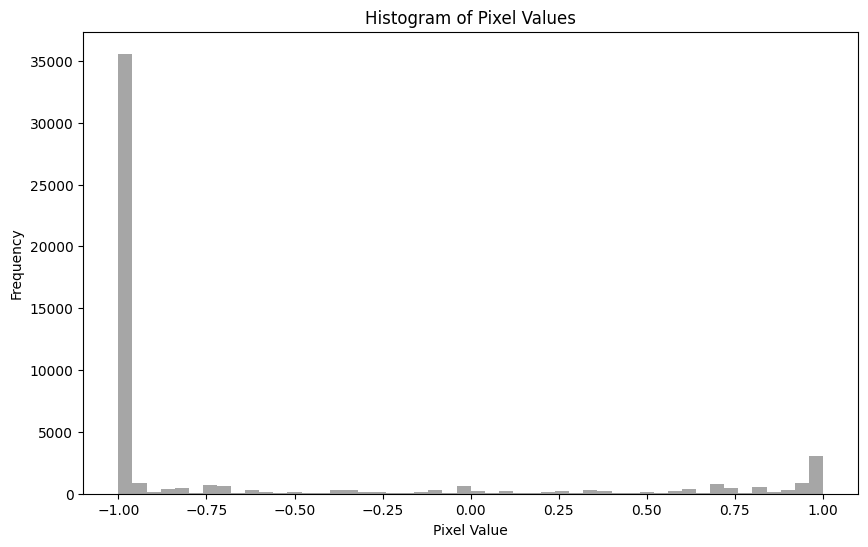

In [8]:
# Plot Histogram
def plot_pixel_histogram(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images = images.view(-1)

    plt.figure(figsize=(10, 6))
    plt.hist(images.numpy(), bins=50, color='gray', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Pixel Values')
    plt.show()

plot_pixel_histogram(data_loader)

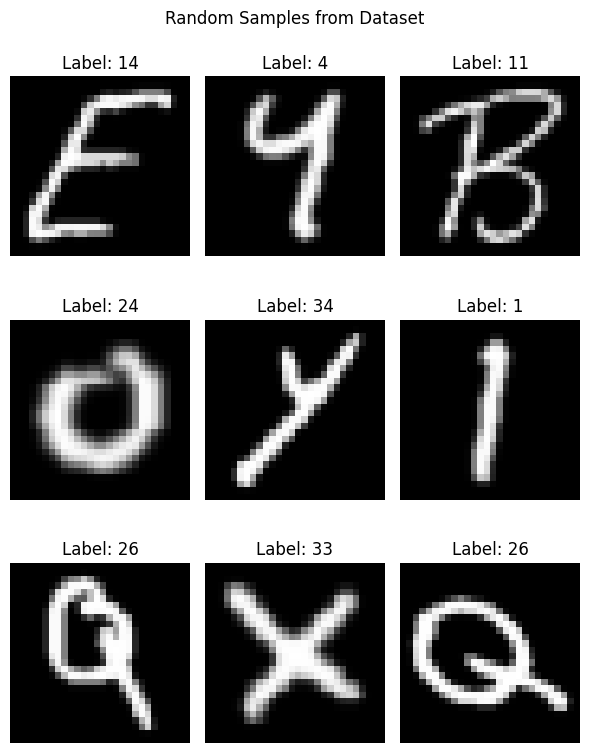

In [9]:
# Visualize the dataset
def show_random_images(data_loader):
    # Get a batch of images and their labels
    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    images = images[:9]

    fig, axes = plt.subplots(3, 3, figsize=(6, 8))
    fig.suptitle('Random Samples from Dataset')

    for i, ax in enumerate(axes.flat):
        img = images[i].squeeze(0).numpy()
        label = labels[i].item()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(data_loader)

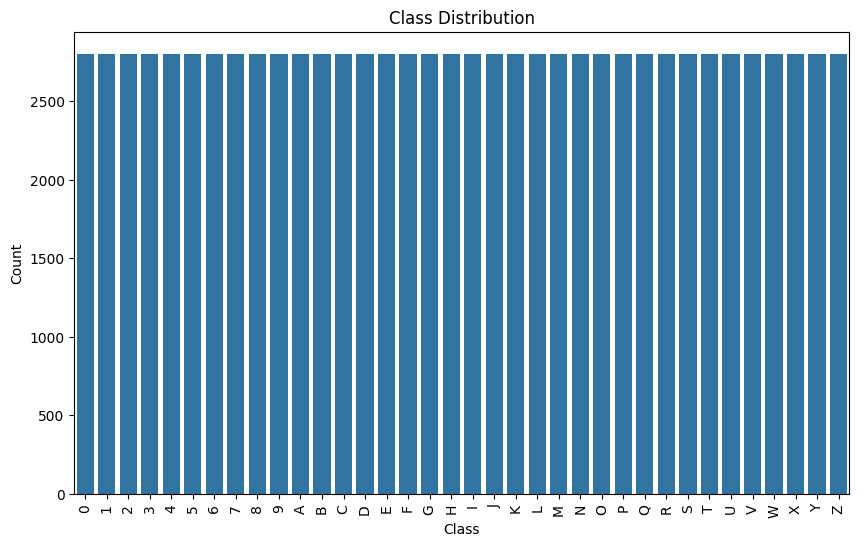

In [10]:
# Visualize the class distribution of the dataset
def plot_class_distribution(emnist_dataset):
    class_counts = [0] * len(emnist_dataset.classes)
    for _, label in emnist_dataset:
        class_counts[label] += 1

    plt.figure(figsize=(10, 6))
    sns.barplot(x=emnist_dataset.classes, y=class_counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.xticks(rotation=90)
    plt.show()

plot_class_distribution(emnist_dataset)

In [11]:
# Define sizes of train, test and validation data as 70:15:15 of dataset
train_size = int(0.7 * len(emnist_dataset))
val_size = int(0.15 * len(emnist_dataset))
test_size = len(emnist_dataset) - train_size - val_size

In [12]:
# Split the dataset in train, test and validation data
train_dataset, val_dataset, test_dataset = random_split(emnist_dataset, [train_size, val_size, test_size])

In [13]:
# Create data loaders for train, test and validation data
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 70560
Validation dataset size: 15120
Test dataset size: 15120


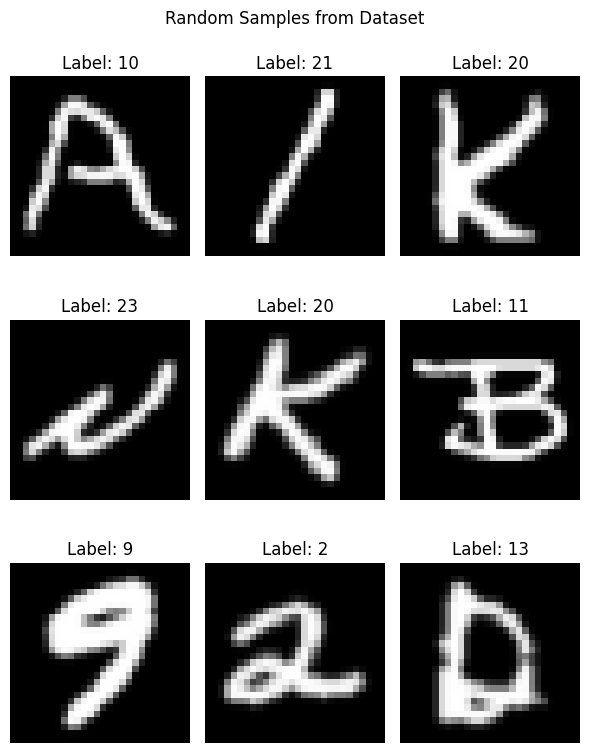

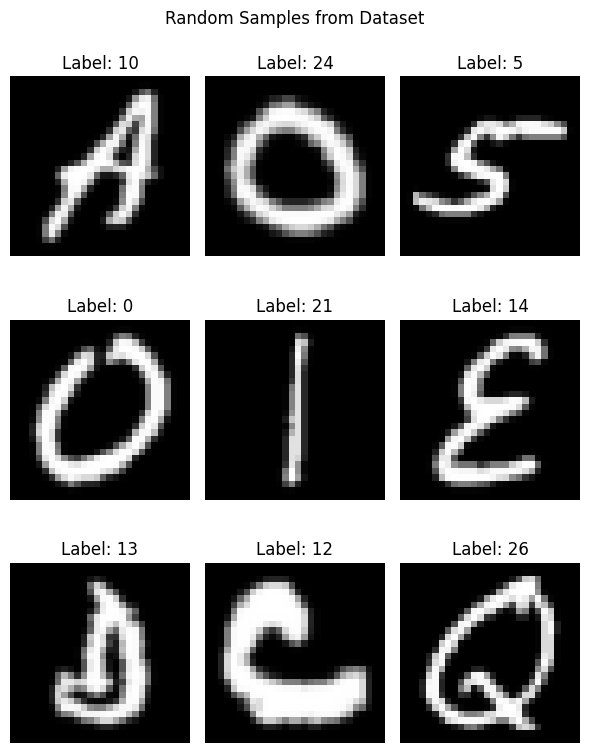

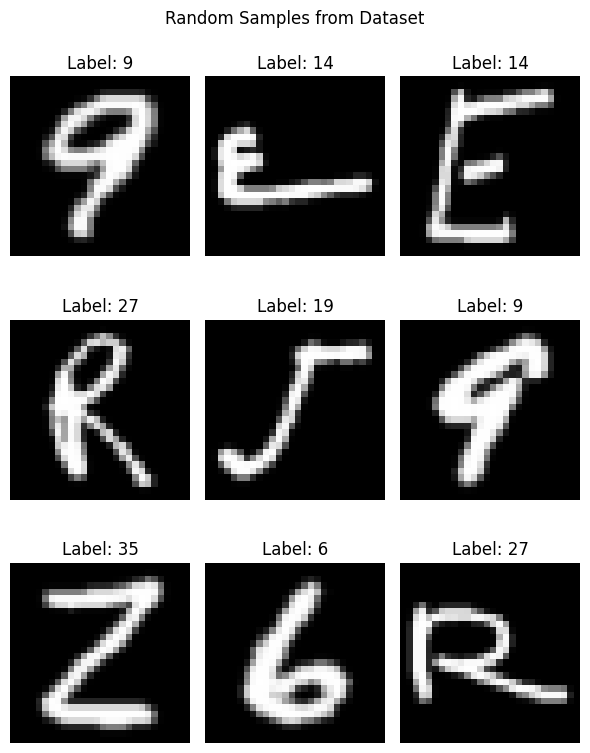

In [ ]:
# Snapshot of the dataset from train, validation and test datasets
show_random_images(train_loader)
show_random_images(val_loader)
show_random_images(test_loader)

#### 2. Build and train a basic CNN (with max 10 hidden layers). Decide your CNN architecture:

<ul>
    <li>Input Neurons: The images are grayscale, with the size of 28×28. Therefore, the size will be 1 × 28 × 28 (1 channel for grayscale).</li>
    <li>Output Neurons: The total number of output neurons applied would depend on the number of classes. For example, in the case of Byclass split, there are 62 classes; that is, 26 uppercase and 26 lowercase letters with 10 digits. Of course, this might change based on your split.</li>
    <li>Activation Function: ReLU is used in general for hidden layers because it is simple and efficient. We are going to go with ReLU for hidden layers, and for an output layer (in the case of multi-class classification problems), we stick with Softmax. </li>
    <li>Hidden Layers: We will make use of a few convolutional and pooling layers followed by fully connected layers. </li>
    <li>Layer Sizes: Traditional - The number of channels will increase with each convolutional layer. For example, 32, 64, then fully connected layers.</li>
    <li>Dropout: By adding this between layers, it will prevent overfitting with a probability of 0.5.</li>
</ul>

#### 3. Define your CNN architecture using PyTorch

In [16]:
import torch.nn as nn
import torch.optim as optim

In [17]:
# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Conv1 + Pool + ReLU
        x = self.pool(self.relu(self.conv1(x)))
        # Conv2 + Pool + ReLU
        x = self.pool(self.relu(self.conv2(x)))
        # Flatten
        x = x.view(-1, 64 * 7 * 7)
        # FC1 + Dropout + ReLU
        x = self.dropout(self.relu(self.fc1(x)))
        # FC2 (output layer)
        x = self.fc2(x)
        # Softmax for multi-class classification
        return self.softmax(x)

In [18]:
# Instantiate the CNN model
num_classes = len(emnist_dataset.classes)
cnn_model = CNNModel(num_classes=num_classes)

#### 4. Return the summary of your model.

In [21]:
# Summary of the neural network
from torchinfo import summary

summary(cnn_model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 36]                   --
├─Conv2d: 1-1                            [32, 28, 28]              320
├─ReLU: 1-2                              [32, 28, 28]              --
├─MaxPool2d: 1-3                         [32, 14, 14]              --
├─Conv2d: 1-4                            [64, 14, 14]              18,496
├─ReLU: 1-5                              [64, 14, 14]              --
├─MaxPool2d: 1-6                         [64, 7, 7]                --
├─Linear: 1-7                            [1, 128]                  401,536
├─ReLU: 1-8                              [1, 128]                  --
├─Dropout: 1-9                           [1, 128]                  --
├─Linear: 1-10                           [1, 36]                   4,644
├─Softmax: 1-11                          [1, 36]                   --
Total params: 424,996
Trainable params: 424,996
Non-trainable params: 0


#### 5. Train your model. You can refer to the code from your Part I implementation.

In [22]:
import time

In [23]:
# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [ ]:
num_epochs = 20

cnn_train_loss = []
cnn_val_loss = []
cnn_train_acc = []
cnn_val_acc = []

st = time.time()
# Training the model
for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculating training accuracy and loss
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = 100 * correct_train / total_train
    cnn_train_loss.append(epoch_train_loss)
    cnn_train_acc.append(epoch_train_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_acc:.2f}%")

    # Validating the model
    cnn_model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = cnn_model(images)
            loss = loss_function(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            # Calculating validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculating validation accuracy and loss
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_acc = 100 * correct_val / total_val
    cnn_val_loss.append(epoch_val_loss)
    cnn_val_acc.append(epoch_val_acc)
    print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%")

cnn_training_time = time.time() - st
print(f"Training complete in {cnn_training_time // 60:.0f}m {cnn_training_time % 60:.0f}s")

Epoch [1/20], Training Loss: 3.2004, Training Accuracy: 43.46%
Validation Loss: 2.9679, Validation Accuracy: 66.41%
Epoch [2/20], Training Loss: 2.9888, Training Accuracy: 64.53%
Validation Loss: 2.8734, Validation Accuracy: 75.73%
Epoch [3/20], Training Loss: 2.9310, Training Accuracy: 70.17%
Validation Loss: 2.8586, Validation Accuracy: 77.21%
Epoch [4/20], Training Loss: 2.9135, Training Accuracy: 71.82%
Validation Loss: 2.8522, Validation Accuracy: 77.86%
Epoch [5/20], Training Loss: 2.8822, Training Accuracy: 74.97%
Validation Loss: 2.8012, Validation Accuracy: 82.92%
Epoch [6/20], Training Loss: 2.8550, Training Accuracy: 77.70%
Validation Loss: 2.7947, Validation Accuracy: 83.62%
Epoch [7/20], Training Loss: 2.8467, Training Accuracy: 78.46%
Validation Loss: 2.7961, Validation Accuracy: 83.39%
Epoch [8/20], Training Loss: 2.8413, Training Accuracy: 78.98%
Validation Loss: 2.7921, Validation Accuracy: 83.84%
Epoch [9/20], Training Loss: 2.8360, Training Accuracy: 79.51%
Validatio

In [ ]:
# Testing the model on test data
cnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

cnn_test_accuracy = 100 * correct / total
print(f"Test Accuracy: {cnn_test_accuracy:.2f}%")

Test Accuracy: 85.36%


#### 6. Add at least three improvement methods that you tried for “Part II - Step 4” of this assignment, that are applicable to CNN architecture.

In [ ]:
import copy

early_stopping_train_loss = []
early_stopping_val_loss = []
early_stopping_train_acc = []
early_stopping_val_acc = []

# Tuning model by using Early stopping
patience = 3
best_val_loss = np.inf
epochs_no_improve = 0

early_stopping_model = copy.deepcopy(cnn_model)
st = time.time()

for epoch in range(num_epochs):
    early_stopping_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training the model
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = early_stopping_model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Calculating training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    early_stopping_train_loss.append(epoch_loss)
    early_stopping_train_acc.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validating the model
    early_stopping_model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = early_stopping_model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct_val / total_val
    early_stopping_val_loss.append(val_loss)
    early_stopping_val_acc.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Checking early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

early_stopping_training_time = time.time() - st
print(f"Training complete in {early_stopping_training_time // 60:.0f}m {early_stopping_training_time % 60:.0f}s")

Epoch [1/20], Training Loss: 2.8083, Training Accuracy: 82.18%
Validation Loss: 2.7768, Validation Accuracy: 85.36%
Epoch [2/20], Training Loss: 2.8094, Training Accuracy: 82.12%
Validation Loss: 2.7768, Validation Accuracy: 85.36%
Epoch [3/20], Training Loss: 2.8074, Training Accuracy: 82.29%
Validation Loss: 2.7768, Validation Accuracy: 85.36%
Epoch [4/20], Training Loss: 2.8095, Training Accuracy: 82.05%
Validation Loss: 2.7768, Validation Accuracy: 85.36%
Early stopping!
Training complete in 11m 42s


In [ ]:
# Calculating test accuracy, precision, recall and F1 score
from sklearn.metrics import precision_recall_fscore_support

early_stopping_model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = early_stopping_model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculating accuracy
early_stopping_accuracy = 100 * correct / total

# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

print(f"Test Accuracy: {early_stopping_accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Test Accuracy: 85.36%
Precision: 0.8068
Recall: 0.8518
F1 Score: 0.8240


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# CNN Model architecture with Batch Normalization
class CNNWithBatchNorm(nn.Module):
    def __init__(self, num_classes):
        super(CNNWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
num_classes = len(emnist_dataset.classes)
cnn_batch_norm_model = CNNWithBatchNorm(num_classes=num_classes)

In [ ]:
# Defining loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_batch_norm_model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10

batch_norm_cnn_train_loss = []
batch_norm_cnn_val_loss = []
batch_norm_cnn_train_acc = []
btach_norm_cnn_val_acc = []

st = time.time()
# Training the model
for epoch in range(num_epochs):
    cnn_batch_norm_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = cnn_batch_norm_model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculating training accuracy and loss
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = 100 * correct_train / total_train
    batch_norm_cnn_train_loss.append(epoch_train_loss)
    batch_norm_cnn_train_acc.append(epoch_train_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_acc:.2f}%")

    # Validating model
    cnn_batch_norm_model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = cnn_batch_norm_model(images)
            loss = loss_function(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            # Calculating validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculating validation accuracy and loss
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_acc = 100 * correct_val / total_val
    batch_norm_cnn_val_loss.append(epoch_val_loss)
    btach_norm_cnn_val_acc.append(epoch_val_acc)
    print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%")

batch_norm_training_time = time.time() - st
print(f"Training complete in {batch_norm_training_time // 60:.0f}m {cnn_training_time % 60:.0f}s")

Epoch [1/10], Training Loss: 0.4384, Training Accuracy: 84.34%
Validation Loss: 0.2845, Validation Accuracy: 89.46%
Epoch [2/10], Training Loss: 0.4133, Training Accuracy: 85.30%
Validation Loss: 0.2797, Validation Accuracy: 89.79%
Epoch [3/10], Training Loss: 0.3965, Training Accuracy: 85.70%
Validation Loss: 0.2639, Validation Accuracy: 90.62%
Epoch [4/10], Training Loss: 0.3797, Training Accuracy: 86.29%
Validation Loss: 0.2775, Validation Accuracy: 89.74%
Epoch [5/10], Training Loss: 0.3575, Training Accuracy: 86.75%
Validation Loss: 0.2690, Validation Accuracy: 90.20%
Epoch [6/10], Training Loss: 0.3452, Training Accuracy: 87.12%
Validation Loss: 0.2677, Validation Accuracy: 90.23%
Epoch [7/10], Training Loss: 0.3345, Training Accuracy: 87.57%
Validation Loss: 0.2563, Validation Accuracy: 90.60%
Epoch [8/10], Training Loss: 0.3231, Training Accuracy: 88.00%
Validation Loss: 0.2654, Validation Accuracy: 90.62%
Epoch [9/10], Training Loss: 0.3158, Training Accuracy: 88.02%
Validatio

In [ ]:
cnn_batch_norm_model.eval()
correct = 0
total = 0
batch_norm_labels = []
batch_norm_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn_batch_norm_model(images)
        _, predicted = torch.max(outputs.data, 1)

        batch_norm_labels.extend(labels.numpy())
        batch_norm_preds.extend(predicted.numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculating accuracy
bn_accuracy = 100 * correct / total

# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(batch_norm_labels, batch_norm_preds, average='macro')

print(f"Test Accuracy: {bn_accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Test Accuracy: 90.89%
Precision: 0.9154
Recall: 0.9070
F1 Score: 0.9067


In [ ]:
# Tuning model using Gradient Accumulation
ga_train_loss = []
ga_val_loss = []
ga_train_acc = []
ga_val_acc = []

accumulation_steps = 4 

st = time.time()
ga_cnn_model = copy.deepcopy(cnn_model)

for epoch in range(num_epochs):
    ga_cnn_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    optimizer.zero_grad()

    # Training the model
    for i, (images, labels) in enumerate(train_loader):
        outputs = ga_cnn_model(images)
        loss = loss_function(outputs, labels) / accumulation_steps
        loss.backward() 

        running_loss += loss.item() * accumulation_steps * images.size(0)

        # Calculating training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Optimizing the step after accumulation_steps mini-batches
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            # Reseting the gradients after update
            optimizer.zero_grad()  

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    ga_train_loss.append(epoch_loss)
    ga_train_acc.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validating the model
    ga_cnn_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = ga_cnn_model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct_val / total_val
    ga_val_loss.append(val_loss)
    ga_val_acc.append(val_accuracy)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

ga_training_time = time.time() - st
print(f"Training complete in {ga_training_time // 60:.0f}m {ga_training_time % 60:.0f}s")

Epoch [1/10], Training Loss: 2.8077, Training Accuracy: 82.28%
Validation Loss: 2.7768, Validation Accuracy: 85.36%
Epoch [2/10], Training Loss: 2.8079, Training Accuracy: 82.25%
Validation Loss: 2.7768, Validation Accuracy: 85.36%
Epoch [3/10], Training Loss: 2.8098, Training Accuracy: 82.07%
Validation Loss: 2.7768, Validation Accuracy: 85.36%
Epoch [4/10], Training Loss: 2.8092, Training Accuracy: 82.13%
Validation Loss: 2.7768, Validation Accuracy: 85.36%
Epoch [5/10], Training Loss: 2.8096, Training Accuracy: 82.05%
Validation Loss: 2.7768, Validation Accuracy: 85.36%
Epoch [6/10], Training Loss: 2.8087, Training Accuracy: 82.16%
Validation Loss: 2.7768, Validation Accuracy: 85.36%
Epoch [7/10], Training Loss: 2.8085, Training Accuracy: 82.17%
Validation Loss: 2.7768, Validation Accuracy: 85.36%
Epoch [8/10], Training Loss: 2.8082, Training Accuracy: 82.21%
Validation Loss: 2.7768, Validation Accuracy: 85.36%
Epoch [9/10], Training Loss: 2.8084, Training Accuracy: 82.20%
Validatio

In [ ]:
ga_cnn_model.eval()
correct = 0
total = 0
ga_labels = []
ga_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = ga_cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)

        ga_labels.extend(labels.numpy())
        ga_preds.extend(predicted.numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculating accuracy
ga_accuracy = 100 * correct / total

# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(ga_labels, ga_preds, average='macro')

print(f"Test Accuracy: {ga_accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Test Accuracy: 85.36%
Precision: 0.8068
Recall: 0.8518
F1 Score: 0.8240


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Storing the details of all the models for compairing them
res = {}
res['Base Model'] = {
    'accuracy': cnn_test_accuracy,
    'model': cnn_model,
    'training_time': cnn_training_time
    }
res['Early Stopping'] = {
    'accuracy': early_stopping_accuracy,
    'model': early_stopping_model,
    'training_time': early_stopping_training_time
    }
res['Batch Normalization'] = {
    'accuracy': bn_accuracy,
    'model': cnn_batch_norm_model,
    'training_time': batch_norm_training_time
    }
res['Gradient Accumulation'] = {
    'accuracy': ga_accuracy,
    'model': ga_cnn_model,
    'training_time': ga_training_time
    }

In [ ]:
# Storing the list of training accuracy, training loss, validation accuracy and validation loss for every model
train_val_data = {}
train_val_data['Base Model'] = {
    'train_losses': cnn_train_loss,
    'val_losses': cnn_val_loss,
    'train_accuracies': cnn_train_acc,
    'val_accuracies': cnn_val_acc
}
train_val_data['Early Stopping'] = {
    'train_losses': early_stopping_train_loss,
    'val_losses': early_stopping_val_loss,
    'train_accuracies': early_stopping_train_acc,
    'val_accuracies': early_stopping_val_acc
}
train_val_data['Batch Normalization'] = {
    'train_losses': batch_norm_cnn_train_loss,
    'val_losses': batch_norm_cnn_val_loss,
    'train_accuracies': batch_norm_cnn_train_acc,
    'val_accuracies': btach_norm_cnn_val_acc,
}
train_val_data['Gradient Accumulation'] = {
    'train_losses': ga_train_loss,
    'val_losses': ga_val_loss,
    'train_accuracies': ga_train_acc,
    'val_accuracies': ga_val_acc
}

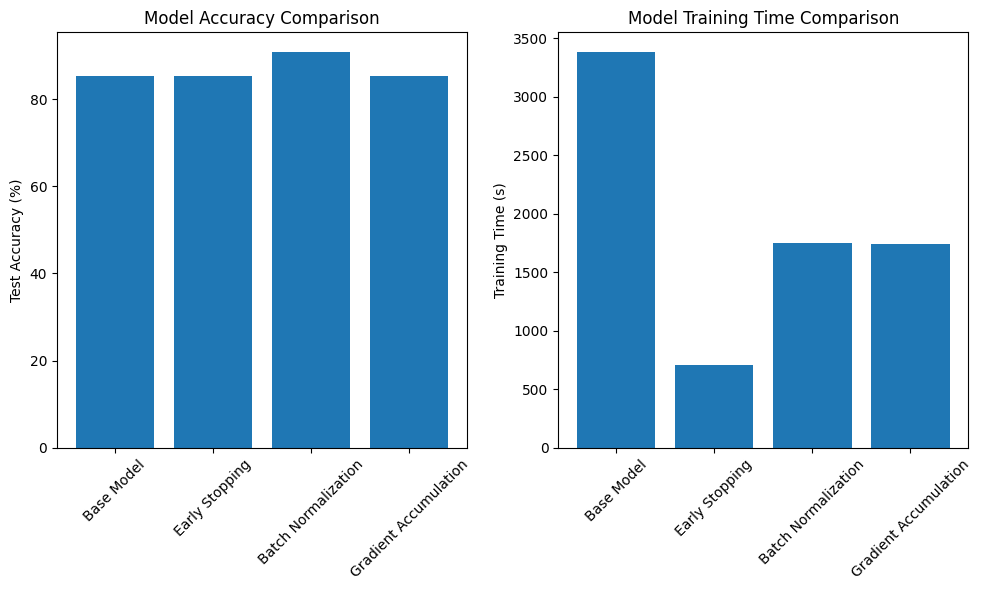

In [ ]:
# Plotting the accuracies and training time for all the models
model_names = list(res.keys())
accuracies = [model_info['accuracy'] for model_info in res.values()]
training_times = [model_info['training_time'] for model_info in res.values()]

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.bar(res.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Test Accuracy (%)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(res.keys(), training_times)
plt.title('Model Training Time Comparison')
plt.ylabel('Training Time (s)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### 7. Save the weights of the trained neural network that returns the best results.

In [39]:
# Identify best model
best_method = max(res.items(), key=lambda x: x[1]['accuracy'])[0]
best_accuracy = res[best_method]['accuracy']

print(f"\nBest performing method: {best_method}")
print(f"Best accuracy: {best_accuracy:.2f}%")
print(f"Best training time: {res[best_method]['training_time']:.2f} seconds")


Best performing method: Batch Normalization
Best accuracy: 90.89%
Best training time: 1749.91 seconds


In [40]:
best_train_val_data = train_val_data[best_method]

In [ ]:
# Saving the weights of the best model
best_model = res[best_method]['model']
torch.save(best_model.state_dict(), 'swetasah_assignment2_part_3.pth')

#### 8. Evaluate the performance of the model on the testing data.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import torch

best_model.eval()
correct = 0
total = 0
best_model_labels = []
best_model_preds = []
test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)

        best_model_labels.extend(labels.numpy())
        best_model_preds.extend(predicted.numpy())

        loss = loss_function(outputs, labels)
        test_loss += loss.item() * images.size(0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculating test loss
test_loss /= total

# Calculating test accuracy
best_model_accuracy = 100 * correct / total

# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(best_model_labels, best_model_preds, average='macro')

print(f"Test Accuracy: {best_model_accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Training Time: {res[best_method]['training_time']:.2f} seconds")

Test Accuracy: 90.89%
Precision: 0.9154
Recall: 0.9070
F1 Score: 0.9067
Training Time: 1749.91 seconds


### 9. Visualize the results. Include the following graphs:

<ol type='a'>
    <li>A graph that compares training, validation and test accuracy on the same plot with clear labeling.</li>
    <li>A graph that compares training, validation and test loss on the same plot with a clear labeling.</li>
    <li>Confusion matrices on the test data</li>
    <li>ROC curve (receiver operating characteristic curve).</li>
</ol>

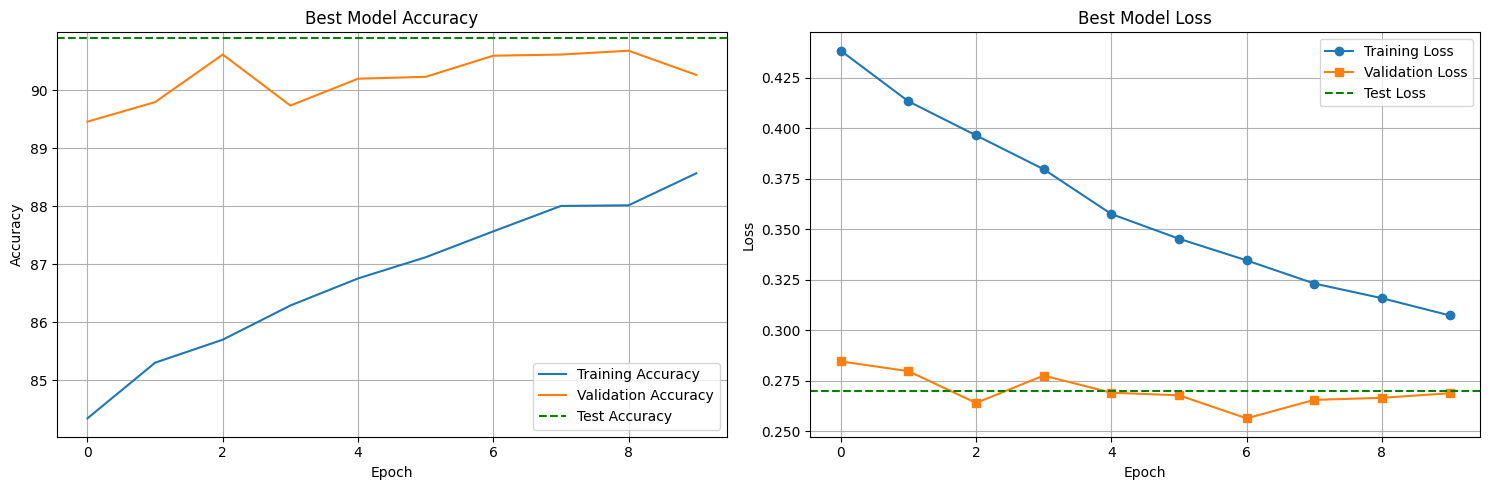

In [ ]:
# Plotting training, validation and test accracy and loss for best model
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(best_train_val_data['train_accuracies'], label='Training Accuracy')
plt.plot(best_train_val_data['val_accuracies'], label='Validation Accuracy')
plt.axhline(y=best_model_accuracy, color='g', linestyle='--', label='Test Accuracy')
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(best_train_val_data['train_losses'], label='Training Loss', marker='o')
plt.plot(best_train_val_data['val_losses'], label='Validation Loss', marker='s')
plt.axhline(y=test_loss, color='g', linestyle='--', label='Test Loss')
plt.title('Best Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

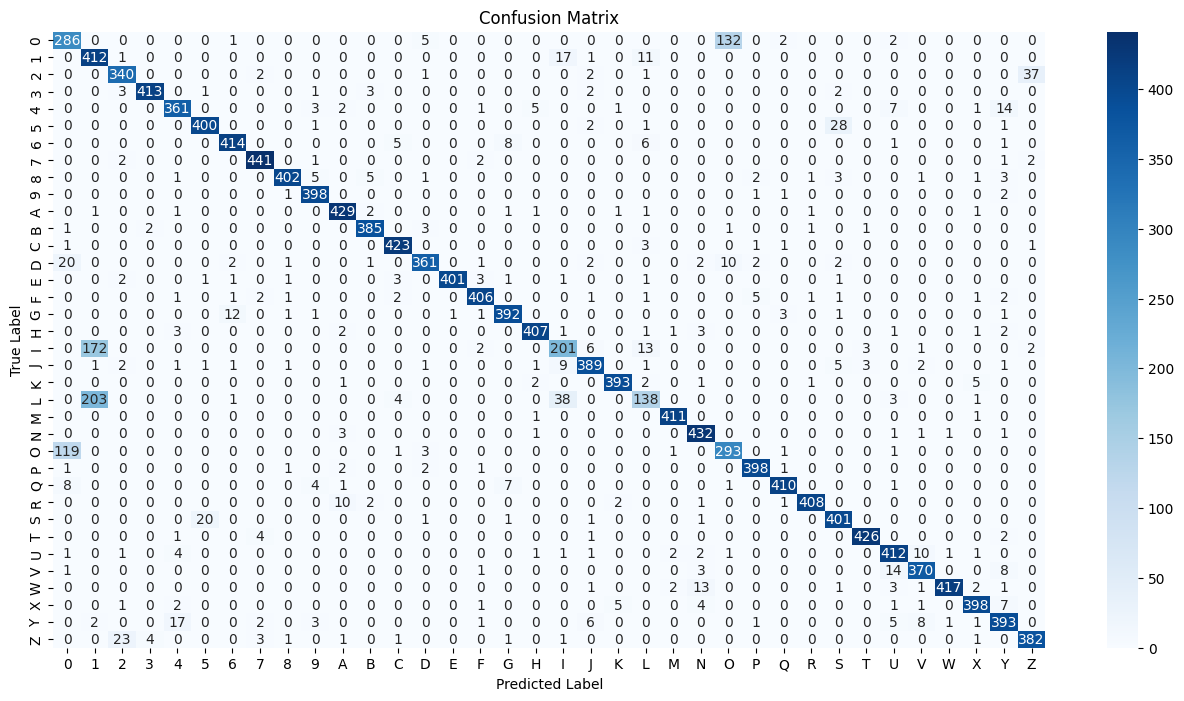

In [ ]:
# Confusion matrix for the best model
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(best_model_labels, best_model_preds)

class_names = [str(i) for i in emnist_dataset.classes]

plt.figure(figsize=(16, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

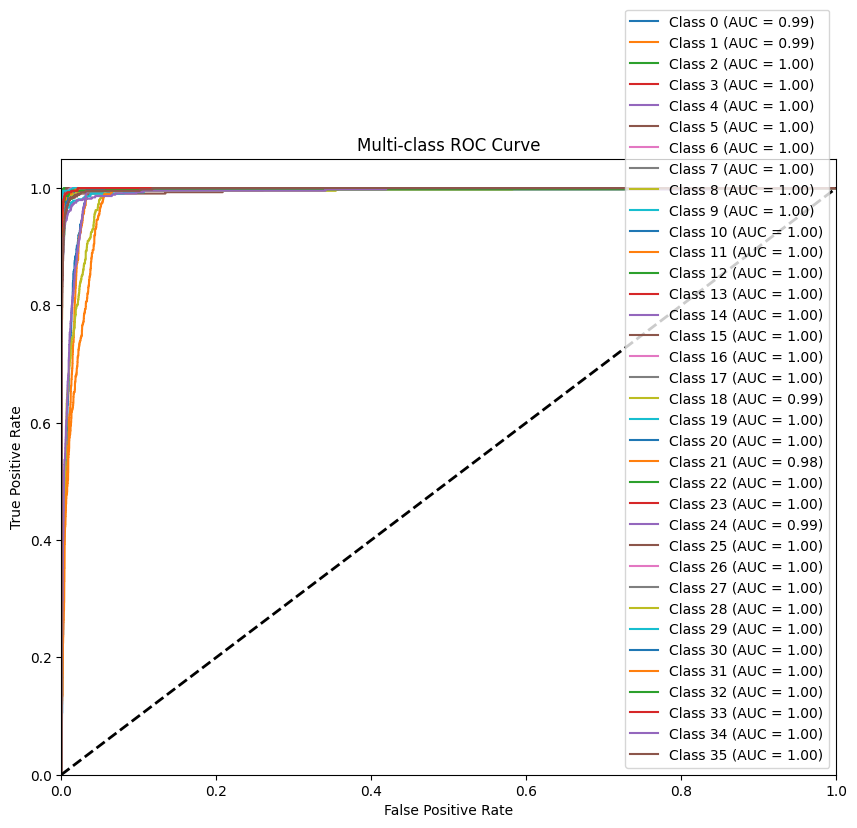

In [ ]:
from torchmetrics.classification import MulticlassROC, MulticlassAUROC
from sklearn.metrics import roc_auc_score

best_model.eval()
softmax = torch.nn.Softmax(dim=1)
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_model(images)
        probs = softmax(outputs) 
        all_probs.append(probs)
        all_labels.append(labels)

all_probs = torch.cat(all_probs)
all_labels = torch.cat(all_labels)

n_classes = len(emnist_dataset.classes)

roc = MulticlassROC(num_classes=n_classes)
auroc = MulticlassAUROC(num_classes=n_classes)

# Computing ROC
fpr, tpr, _ = roc(all_probs, all_labels)

# Computing AUC for each class
auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(all_labels.cpu().numpy() == i, all_probs.cpu().numpy()[:, i])
    auc_scores.append(auc)


# Plotting ROC for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i].cpu().numpy(), tpr[i].cpu().numpy(), label=f'Class {i} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### References

In [ ]:
# https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
# https://pytorch.org/docs/stable/data.html
# https://matplotlib.org/stable/tutorials/images.html
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam
# https://lightning.ai/docs/torchmetrics/stable/classification/auroc.html
# https://lightning.ai/docs/torchmetrics/stable/classification/roc.html